# Harpy support for InstanSeg segmentation model

This notebook provides a minimal example to show how to run [instanseg](https://github.com/instanseg/instanseg), a pytorch based cell and nucleus segmentation pipeline for fluorescent and brightfield microscopy images. More information here:

Goldsborough, T., O’Callaghan, A., Inglis, F., *et al.* (2024). *A novel channel invariant architecture for the segmentation of cells and nuclei in multiplexed images using InstanSeg.* **bioRxiv.** [https://doi.org/10.1101/2024.09.04.611150](https://doi.org/10.1101/2024.09.04.611150)


## Installation: 

``` bash
uv venv .venv_harpy_instanseg --python=3.11
source .venv_harpy_instanseg/bin/activate
uv pip install spatialdata==0.4.0 # instanseg depends on numpy<2, while spatialdata>0.4.0 requires numpy>=2.
uv pip install "git+https://github.com/saeyslab/harpy.git@main#egg=harpy-analysis[extra]"
uv pip install "git+https://github.com/instanseg/instanseg.git@main"
```

## 1. Run `instanseg` example code

This is a minimal example to show how to run the code and notebook provided in the [instanseg](https://github.com/instanseg/instanseg/blob/main/notebooks/segmentation_minimal.ipynb) repository.


In [1]:
import torch

from harpy.datasets.registry import get_ome_registry

registry = get_ome_registry(
    path=None
)  # if path is None, example .tif will be downloaded in the default cache folder of your os.
path = registry.fetch("Vectra-QPTIFF/perkinelmer/PKI_fields/LuCa-7color_%5b13860,52919%5d_1x1component_data.tif")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
import os

import torch
from instanseg import InstanSeg

# Call the function to download and extract the models

instanseg_brightfield = InstanSeg("brightfield_nuclei", verbosity=1, device="cpu")
instanseg_fluorescence = InstanSeg("fluorescence_nuclei_and_cells", verbosity=1, device="cpu")

# or load the model from a path
path_model = os.path.join(
    os.environ.get("INSTANSEG_BIOIMAGEIO_PATH"), "fluorescence_nuclei_and_cells/0.1.1/instanseg.pt"
)
instanseg_fluorescence = torch.load(path_model, weights_only=False)
instanseg_fluorescence = InstanSeg(model_type=instanseg_fluorescence, device=device)

Model brightfield_nuclei version 0.1.1 already downloaded in /Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/, loading
Model fluorescence_nuclei_and_cells version 0.1.1 already downloaded in /Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/, loading


/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


Use `instanseg` to get the pixel size of the image

In [3]:
# we can also use instanseg to get the pixel size
image_array, pixel_size = instanseg_fluorescence.read_image(path)
print(f"Physical pixel size is {pixel_size} μm.")
print(f"image dimensions are (c,y,x): {image_array.shape}.")

Physical pixel size is 0.49799447890790055 μm.
image dimensions are (c,y,x): (1400, 1868, 8).


/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/nn/modules/module.py:1786: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return forward_call(*args, **kwargs)


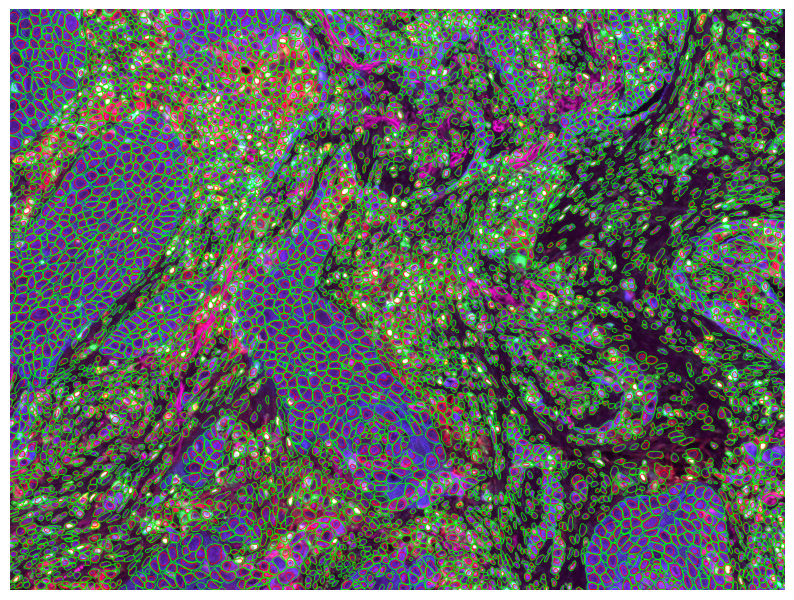

In [4]:
from instanseg.utils.utils import show_images

image_array, pixel_size = instanseg_fluorescence.read_image(path)

# transpose, so we have (c,y,x)
image_array = image_array.transpose(2, 0, 1)

labeled_output, image_tensor = instanseg_fluorescence.eval_small_image(
    image_array,
    pixel_size,
    resolve_cell_and_nucleus=True,
    cleanup_fragments=True,
    target="all_outputs",
)  # "all_outputs", "nuclei", or "cells".

display = instanseg_fluorescence.display(image_tensor, labeled_output)

show_images(display, colorbar=False)

## 2. Run `instanseg` with Harpy support

This is the same example, but using the Harpy library to run the code. The same model is loaded from the Instanseg repository and the code is executed on SpatialData objects.

- The same dataset is used, loaded in SpatialData using `harpy.datasets.vectra_example`.

- You can either run the segmentation model directly or via the Harpy segment function `harpy.im.segment`.


In [5]:
import harpy as hp

sdata = hp.datasets.vectra_example()
sdata

/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


SpatialData object
└── Images
      └── 'image': DataArray[cyx] (8, 1400, 1868)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images)

(0.0, 1868.0, 1400.0, 0.0)

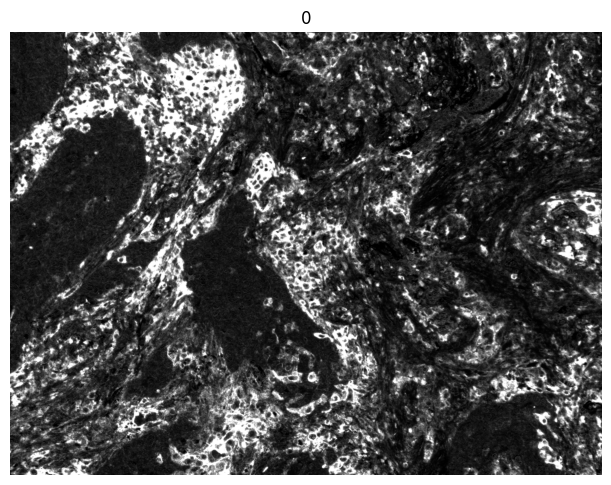

In [6]:
from matplotlib.colors import Normalize

import spatialdata_plot  # noqa: F401

norm = Normalize(vmin=0, vmax=10, clip=True)

channel = 0

render_images_kwargs = {
    "cmap": "grey",
    "norm": norm,
}
show_kwargs = {"title": str(channel), "colorbar": False, "dpi": 100, "figsize": (6, 6)}

ax = hp.pl.plot_sdata(
    sdata,
    img_layer="image",
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    channel=[0],
)
ax.axis("off")

### 2.1 Run just the `instanseg` model

The `instanseg` model is implementated as a Harpy segmentation model (a callable). It can be called like a function using the right arguments and segment the image.

A caveat is that Harpy segmentation models use data formatted as (z, y, x, c) as both input and output. The code above and the data in SpatialData objects is ordered as (c, y, x).

In [7]:
image_array = sdata["image"].to_numpy().transpose(1, 2, 0)[None]
image_array.shape  # -> (z,y,x,c)

(1, 1400, 1868, 8)

In [8]:
labels = hp.im.instanseg_callable(
    img=image_array,
    device=device,
    instanseg_model=instanseg_fluorescence,
    pixel_size=pixel_size,
    output="all_outputs",
)
labels.shape  # ->z,y,x,c

/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(1, 1400, 1868, 2)

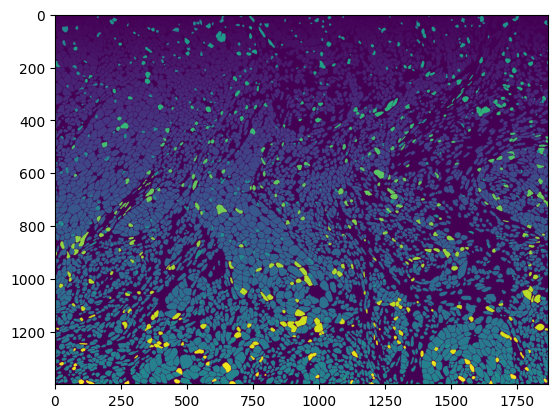

In [9]:
import matplotlib.pyplot as plt

plt.imshow(labels[0, ..., 1])  # plot whole cell masks

### 2.2 Run `instanseg` using the Harpy segment function (recommended)

This is the most convenient way to run the model. It takes care of loading the model, running the segmentation on large images and returning the results in a SpatialData object as a Labels element. The segmentation process will be distributed using [`Dask`](https://www.dask.org/), ensuring the image is not fully loaded into memory and is instead processed in chunks.

We provide a path to the segmentation model (`instanseg_model` parameter), because a loaded `InstanSeg` model is of type `torch.jit.RecursiveScriptModule`, which is not serializable by `Dask`. Now each call to `hp.im.instanseg_callable` made by `hp.im.segment` (for each chunk), will load an `Instanseg` model, but because the model is small, this does not affect performance or increase memory usage.

In [10]:
# we first back the spatialdata object to a zarr store:

import tempfile
import uuid

from spatialdata import read_zarr

OUTPUT_DIR = tempfile.gettempdir()

zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata.write(zarr_path, overwrite=True)
sdata = read_zarr(sdata.path)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_3da72b78-a63d-41e8-8389-b9c7a4050b83.zarr          


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [11]:
from dask.distributed import Client, LocalCluster

import harpy as hp

print(f"Using device: {device}.")

cluster = LocalCluster(
    n_workers=8
    if device == "cpu"
    else 1,  # if cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
    threads_per_worker=1,
    memory_limit="32GB",
)

client = Client(cluster)

print(client.dashboard_link)

sdata = hp.im.segment(
    sdata,
    img_layer="image",
    output_labels_layer=["labels_nuclei_harpy", "labels_cells_harpy"],
    output_shapes_layer=["shapes_nuclei_harpy", "shapes_cells_harpy"],
    labels_layer_align="labels_cells_harpy",
    chunks=1000,
    model=hp.im.instanseg_callable,
    # parameters passed to hp.im.instanseg_callable
    output="all_outputs",
    device=device,
    instanseg_model=path_model,  # load it in every worker, because torchscript model is not serializable
    overwrite=True,
)

client.close()

Using device: mps.
http://127.0.0.1:8787/status


/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy_instanseg/lib/python3.11/site-packages/torch/n

Visualize the segmentation mask using `spatialdata-plot`.

(0.0, 1868.0, 1400.0, 0.0)

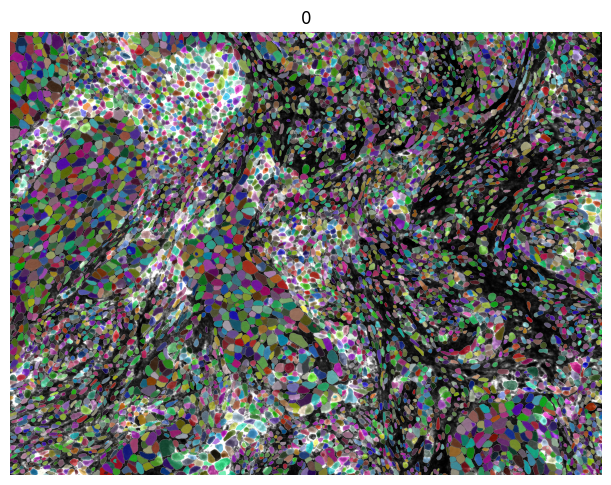

In [12]:
norm = Normalize(vmin=0, vmax=10, clip=True)

channel = 0

render_images_kwargs = {
    "cmap": "grey",
    "norm": norm,
}
render_labels_kwargs = {}
show_kwargs = {"title": str(channel), "colorbar": False, "dpi": 100, "figsize": (6, 6)}

ax = hp.pl.plot_sdata(
    sdata,
    img_layer="image",
    render_images_kwargs=render_images_kwargs,
    labels_layer="labels_cells_harpy",
    show_kwargs=show_kwargs,
    channel=[0],
)
ax.axis("off")

In [13]:
# interactive viewing with napari-spatialdata

# from napari_spatialdata import Interactive

# Interactive( sdata )